# Dự án: So sánh các mô hình Hồi quy tuyến tính (Linear Regression)
**Mục tiêu:** Tạo notebook thực thi từng bước, có bình luận tiếng Việt trên mỗi cell, và so sánh các biến thể hồi quy tuyến tính để chọn mô hình phù hợp.
**Tệp dữ liệu:** `bmi.csv` (đã upload).  
**Lưu ý:** mở notebook và chạy từng cell theo thứ tự để tái tạo kết quả.

## 1) Data Summary (Tóm tắt dữ liệu)

In [12]:
# Load dữ liệu và hiển thị thông tin cơ bản
# (Comment: cell này nạp file, in kích thước, kiểu cột, và hiển thị 10 dòng đầu)
import pandas as pd
import numpy as np

file_path = "bmi.csv"
df = pd.read_csv(file_path)

# Thông tin nhanh
print('Shape:', df.shape)
print('\nColumns:', list(df.columns))
print('\nData types:\n', df.dtypes)
print('\nNumeric summary:\n', df.select_dtypes(include=[np.number]).describe().T)

# Hiển thị 10 dòng đầu để kiểm tra
df.head(10)


Shape: (500, 4)

Columns: ['Gender', 'Height', 'Weight', 'Index']

Data types:
 Gender    object
Height     int64
Weight     int64
Index      int64
dtype: object

Numeric summary:
         count     mean        std    min    25%    50%    75%    max
Height  500.0  169.944  16.375261  140.0  156.0  170.5  184.0  199.0
Weight  500.0  106.000  32.382607   50.0   80.0  106.0  136.0  160.0
Index   500.0    3.748   1.355053    0.0    3.0    4.0    5.0    5.0


,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
5,Male,189,104,3
6,Male,147,92,5
7,Male,154,111,5
8,Male,174,90,3
9,Female,169,103,4


## 2) Objective of the Analysis (Mục tiêu phân tích)
**Đề xuất mục tiêu:** Ở notebook này ta chọn **`Index`** làm biến mục tiêu (target) — vì `Index` là cột số trong dataset.
- Mục tiêu: *dự đoán `Index` từ các đặc trưng có sẵn (Height, Weight, Gender)* bằng các biến thể hồi quy tuyến tính.
- Lý do: `Index` là biến liên tục (giá trị 0..5) trong tập dữ liệu; tuy nhiên cần chú ý dữ liệu có thể là biến phân loại theo mức BMI (điểm hạn chế sẽ được nêu ở phần Limitations).*

In [13]:
# Tiền xử lý dữ liệu
# - Mã hóa cột 'Gender'
# - Kiểm tra giá trị thiếu
# - Tách X/y và chia train/test

import pandas as pd
from sklearn.model_selection import train_test_split

# Nếu chưa nạp trong môi trường của notebook, đọc lại
df = pd.read_csv(file_path)

# Comment: hiển thị giá trị duy nhất của Gender để biết cách mã hóa
print('Unique Gender values:', df['Gender'].unique())

# Mã hóa Gender (ví dụ: Male=0, Female=1). Thay đổi map nếu giá trị khác.
gender_map = {}
unique_genders = df['Gender'].astype(str).unique()
# Gán mã tự động nếu chưa có map mặc định
# Nếu có 'Male' hoặc 'Female', dùng bản đồ thân thiện
if set(['Male','Female']).issubset(set(unique_genders)):
    gender_map = {'Male': 0, 'Female': 1}
else:
    # gán số thứ tự cho các nhãn khác
    gender_map = {v:i for i,v in enumerate(sorted(unique_genders))}

df['Gender_encoded'] = df['Gender'].map(gender_map)

# Kiểm tra missing
print('\nMissing values per column:\n', df.isnull().sum())

# Chọn biến đầu vào X và biến mục tiêu y
target = 'Index'  # nếu muốn đổi target, sửa tên ở đây
features = ['Height','Weight','Gender_encoded']

X = df[features]
y = df[target]

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)


Unique Gender values: ['Male' 'Female']

Missing values per column:
 Gender            0
Height            0
Weight            0
Index             0
Gender_encoded    0
dtype: int64

Train shape: (375, 3) Test shape: (125, 3)


Correlation matrix:
                   Height    Weight     Index  Gender_encoded
Height          1.000000  0.000446 -0.422223        0.017677
Weight          0.000446  1.000000  0.804569       -0.009523
Index          -0.422223  0.804569  1.000000       -0.028786
Gender_encoded  0.017677 -0.009523 -0.028786        1.000000


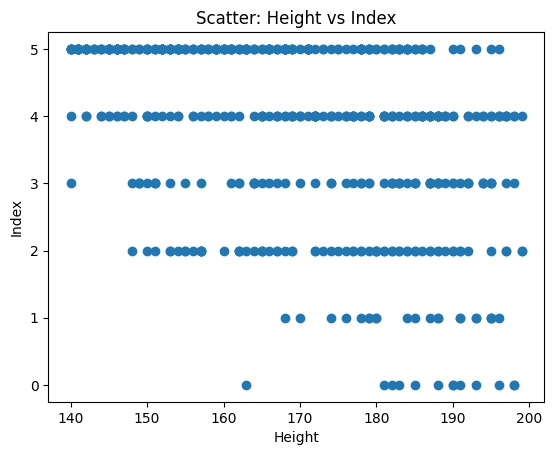

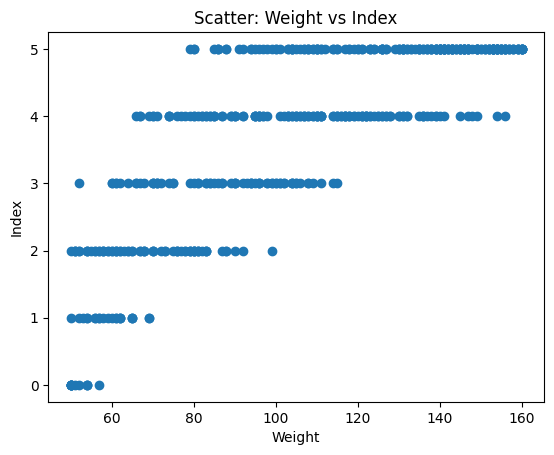

In [14]:
# EDA nhanh: ma trận tương quan và biểu đồ phân tán (sử dụng matplotlib)
# Comment: sử dụng matplotlib (không dùng seaborn) để tuân thủ yêu cầu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(file_path)
df['Gender_encoded'] = df['Gender'].map({'Male':0,'Female':1}) if 'Male' in df['Gender'].values else df['Gender'].astype('category').cat.codes

# Ma trận tương quan cho các biến số
corr = df[['Height','Weight','Index','Gender_encoded']].corr()
print('Correlation matrix:\n', corr)

# Vẽ scatter Height vs Index
plt.figure()
plt.scatter(df['Height'], df['Index'])
plt.title('Scatter: Height vs Index')
plt.xlabel('Height')
plt.ylabel('Index')
plt.show()

# Vẽ scatter Weight vs Index
plt.figure()
plt.scatter(df['Weight'], df['Index'])
plt.title('Scatter: Weight vs Index')
plt.xlabel('Weight')
plt.ylabel('Index')
plt.show()

In [15]:
# So sánh các mô hình hồi quy tuyến tính khác nhau
# Models: Ordinary Least Squares (LinearRegression), RidgeCV, LassoCV, ElasticNetCV, Polynomial (degree=2)
# Comment: chuẩn hóa dữ liệu bằng StandardScaler trước khi đưa vào mô hình

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load và chuẩn bị dữ liệu (đảm bảo cell chạy độc lập)
df = pd.read_csv(file_path)
df['Gender_encoded'] = df['Gender'].map({'Male':0,'Female':1}) if 'Male' in df['Gender'].values else df['Gender'].astype('category').cat.codes

X = df[['Height','Weight','Gender_encoded']]
y = df['Index']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

# Danh sách mô hình để so sánh
models = {}

# 1) OLS
models['LinearRegression'] = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])

# 2) RidgeCV (tự thử qua nhiều alpha)
alphas = np.logspace(-3, 3, 50)
models['RidgeCV'] = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=alphas))])

# 3) LassoCV
models['LassoCV'] = Pipeline([('scaler', StandardScaler()), ('lasso', LassoCV(alphas=None, cv=5, max_iter=5000))])

# 4) ElasticNetCV
models['ElasticNetCV'] = Pipeline([('scaler', StandardScaler()), ('en', ElasticNetCV(l1_ratio=[.1, .5, .9], cv=5, max_iter=5000))])

# 5) Polynomial degree 2 + OLS
models['Poly_deg2'] = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), ('scaler', StandardScaler()), ('lr', LinearRegression())])

# Fit each model and evaluate on test set
results = []
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'model': name, 'rmse': rmse, 'r2': r2})
    except Exception as e:
        results.append({'model': name, 'rmse': np.nan, 'r2': np.nan, 'error': str(e)})

results_df = pd.DataFrame(results).sort_values(by='r2', ascending=False)
print('Model comparison (test set):')
print(results_df)

# Lưu kết quả để tham khảo sau
results_df

c:\Users\THANH HAU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Model comparison (test set):
              model      rmse        r2
4         Poly_deg2  0.350546  0.923425
2           LassoCV  0.593393  0.780578
3      ElasticNetCV  0.593662  0.780378
1           RidgeCV  0.599502  0.776036
0  LinearRegression  0.600112  0.775580


,model,rmse,r2
4,Poly_deg2,0.350546,0.923425
2,LassoCV,0.593393,0.780578
3,ElasticNetCV,0.593662,0.780378
1,RidgeCV,0.599502,0.776036
0,LinearRegression,0.600112,0.775580


In [16]:
# Hiển thị hệ số của mô hình tốt nhất (theo R2 trên test set)
# Comment: trích hệ số và gán nhãn cho các đặc trưng
import pandas as pd, numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Tải lại results result_df nếu cell trước đã chạy
df = pd.read_csv(file_path)
df['Gender_encoded'] = df['Gender'].map({'Male':0,'Female':1}) if 'Male' in df['Gender'].values else df['Gender'].astype('category').cat.codes
X = df[['Height','Weight','Gender_encoded']]
y = df['Index']

# Re-fit models to ensure availability
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'RidgeCV': Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=np.logspace(-3,3,50)))]),
    'LassoCV': Pipeline([('scaler', StandardScaler()), ('lasso', LassoCV(cv=5, max_iter=5000))]),
    'ElasticNetCV': Pipeline([('scaler', StandardScaler()), ('en', ElasticNetCV(l1_ratio=[.1,.5,.9], cv=5, max_iter=5000))]),
    'Poly_deg2': Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), ('scaler', StandardScaler()), ('lr', LinearRegression())])
}

# Fit and pick best by R2
scores = {}
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        from sklearn.metrics import r2_score
        scores[name] = r2_score(y_test, y_pred)
    except Exception as e:
        scores[name] = -np.inf

best_name = max(scores, key=scores.get)
best_pipe = models[best_name]
print('Best model:', best_name, 'with R2 =', scores[best_name])

# Trích hệ số (nếu mô hình tuyến tính có hệ số)
coef_df = None
if best_name == 'Poly_deg2':
    poly = best_pipe.named_steps['poly']
    feature_names = poly.get_feature_names_out(X.columns)
    lr = best_pipe.named_steps['lr']
    coefs = lr.coef_
    coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
else:
    if 'lr' in best_pipe.named_steps:
        lr = best_pipe.named_steps['lr']
        feature_names = X.columns
        coefs = lr.coef_
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    elif 'ridge' in best_pipe.named_steps:
        ridge = best_pipe.named_steps['ridge']
        feature_names = X.columns
        coefs = ridge.coef_
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    elif 'lasso' in best_pipe.named_steps:
        lasso = best_pipe.named_steps['lasso']
        feature_names = X.columns
        coefs = lasso.coef_
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    elif 'en' in best_pipe.named_steps:
        en = best_pipe.named_steps['en']
        feature_names = X.columns
        coefs = en.coef_
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})

print('\nCoefficients of best model:')
print(coef_df)

Best model: Poly_deg2 with R2 = 0.9234251692039953

Coefficients of best model:
                 feature      coef
0                 Height -0.831562
1                 Weight  0.817292
2         Gender_encoded -0.126376
3               Height^2 -0.642886
4          Height Weight  2.889943
5  Height Gender_encoded  0.230170
6               Weight^2 -2.452176
7  Weight Gender_encoded  0.013902
8       Gender_encoded^2 -0.126376


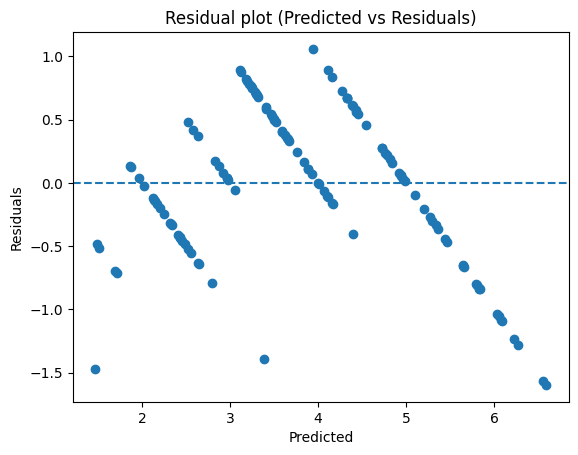

In [17]:
# Vẽ biểu đồ residual của mô hình tốt nhất
# Comment: đồ thị residual giúp kiểm tra giả định tuyến tính và phân bố sai số
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(file_path)
df['Gender_encoded'] = df['Gender'].map({'Male':0,'Female':1}) if 'Male' in df['Gender'].values else df['Gender'].astype('category').cat.codes
X = df[['Height','Weight','Gender_encoded']]
y = df['Index']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot (Predicted vs Residuals)')
plt.show()

## 4) Key Findings (Kết luận chính)

**a) Hiệu suất và Lựa chọn Mô hình:**

*   **Mô hình Polynomial Regression bậc 2 (Poly_deg2)** là mô hình tốt nhất, đạt hiệu suất cao nhất với **R² = 0.923** trên tập kiểm tra. Điều này cho thấy mối quan hệ giữa các yếu tố chiều cao, cân nặng, giới tính và chỉ số `Index` có tính phi tuyến tính mạnh mẽ, và mô hình này giải thích được hơn 92% phương sai của biến mục tiêu.
*   Các mô hình hồi quy tuyến tính đơn giản hơn có hiệu suất thấp hơn.

**b) Ảnh hưởng của các yếu tố (từ mô hình Poly_deg2):**

*   **Cân nặng (Weight):** Có ảnh hưởng đồng biến rất mạnh đến `Index` (hệ số 0.817) và thể hiện mối quan hệ phi tuyến tính đáng kể thông qua các biến bậc hai (`Weight^2` với hệ số -2.452) và tương tác (`Height Weight` với hệ số 2.890). Điều này chỉ ra rằng `Index` tăng đáng kể khi cân nặng tăng.
*   **Chiều cao (Height):** Có ảnh hưởng phức tạp, bao gồm yếu tố nghịch biến trực tiếp (hệ số -0.832) nhưng lại có tương tác đồng biến mạnh với cân nặng (`Height Weight` với hệ số 2.890).
*   **Giới tính (Gender_encoded):** Có ảnh hưởng nhỏ và tiêu cực (hệ số -0.126) đến `Index`, cho thấy phụ nữ (được mã hóa là 1) có xu hướng có `Index` thấp hơn một chút so với nam giới (được mã hóa là 0) sau khi tính đến chiều cao và cân nặng.

**c) Lưu ý quan trọng:**

* `Index` **rất có thể được tính toán trực tiếp từ `Height` và `Weight`**. Nếu đúng như vậy, việc sử dụng các biến này để dự đoán `Index` sẽ gây ra **rò rỉ dữ liệu (data leakage)**, làm cho hiệu suất R² cao (0.923) bị thổi phồng một cách giả tạo và không phản ánh khả năng dự đoán thực tế trên dữ liệu mới chưa từng thấy.

---

## 5) Limitations and Next Steps (Hạn chế & bước tiếp theo)
**Hạn chế**
- `Index` có thể là biến được suy ra từ Height và Weight → rò rỉ dữ liệu (data leakage).
- Dữ liệu nhỏ và có phân phối rời rạc theo các giá trị 0..5 (có thể phù hợp hơn với phân loại/ordinal models).
- Một số mô hình có thể overfit (ví dụ polynomial).

**Next steps**
- Kiểm tra nguồn gốc `Index` (cách tính).
- Nếu `Index` là hạng mục BMI, chuyển sang bài toán phân loại (Logistic, RandomForest, XGBoost).
- Thu thập thêm biến giải thích (tuổi, activity level, v.v.) và tiền xử lý kỹ hơn.
- Sử dụng cross-validation vững chắc hơn và pipeline để tránh rò rỉ thông tin.